In [1]:
import os
import csv
import sys
import numpy as np
import cv2          
import time
from torchvision import transforms
import torch
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import Dataset

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

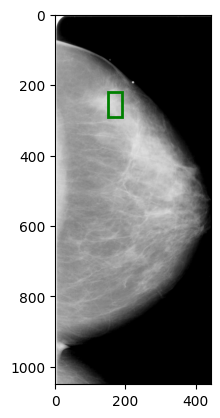

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import csv
import sys
import cv2
def visualize_image_with_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            label, x_center, y_center, width, height = map(float, line.strip().split(' '))
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            boxes.append([x_min, y_min, x_max, y_max])
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
file_label = 'Calc-Training_P_00034_RIGHT_CC.txt' 
image_path = os.path.join('/kaggle/input/cv-a4-data/yolo_1k/val/images', file_label.replace('.txt', '.png'))
label_path = os.path.join('/kaggle/input/cv-a4-data/yolo_1k/val/labels', file_label)

visualize_image_with_boxes(image_path, label_path)


Inference

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def load_model(checkpoint_path):
    #model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
    model = fasterrcnn_resnet50_fpn()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def visualize_predicted_boxes(image, predictions):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

#     for box in predictions['boxes'][0]:
#         print(box)
    box = predictions['boxes'][0].tolist()

    
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.axis('off')
    plt.show()

def main():
    checkpoint_path = "/kaggle/input/finetunepretrained/model (1).pt"
    model = load_model(checkpoint_path)
    model.to(device)
    model.eval()

    image_path = "/kaggle/input/cv-a4-data/yolo_1k/val/images/Calc-Training_P_00034_RIGHT_CC.png"  # Provide the path to the image
    image = cv2.imread(image_path)
   # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    #image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]
#         print(model(image_tensor))
        print(predictions)

    visualize_predicted_boxes(image, predictions)

if __name__ == "__main__":
    main()


In [ ]:
def get_model(num_classes):
    # Load a model pre-trained on COCO
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)

    return model

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images_folder_path = os.path.join(folder_path, 'images')
        self.labels_folder_path = os.path.join(folder_path, 'labels')
        # self.mean = mean
        # self.var = var
        self.transform = transform
        self.filenames = [f for f in os.listdir(self.images_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def get_all_images_and_boxes(self):
        data = []
        for filename in self.filenames:
            image_path = os.path.join(self.images_folder_path, filename)
            image = cv2.imread(image_path)
            #image = cv2.resize(image, (224, 224))
            #image = (image - self.mean) / np.sqrt(self.var)
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)

            label_file_path = os.path.join(self.labels_folder_path, filename.replace('.png', '.txt').replace('.jpg', '.txt'))
            boxes = []
            if os.path.isfile(label_file_path):
                with open(label_file_path, 'r') as file:
                    for line in file:
                        label, x_center, y_center, width, height = map(float, line.strip().split(' '))
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_min + width
                        y_max = y_min + height
                        boxes.append([label, x_min, y_min, x_max, y_max])

            if boxes:
                labels = torch.tensor([b[0] for b in boxes], dtype=torch.int64)
                boxes = torch.tensor(boxes, dtype=torch.float32)
                boxes = boxes[:, 1:]
                #data.append((image, {'boxes': boxes, 'labels': labels}))
                data.append((image.to(device), {'boxes': boxes.to(device), 'labels': labels.to(device)}))


        return data

In [ ]:
def get_mean_var(train_folder, val_folder):
    sum_values = 0
    sum_squares = 0
    num_pixels = 0

    for folder in [train_folder, val_folder]:
        images_folder_path = os.path.join(folder, 'images')
        for filename in os.listdir(images_folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  
                image_path = os.path.join(images_folder_path, filename)
                image = cv2.imread(image_path)
                # Resize image to 224x224
                image = cv2.resize(image, (224, 224))
                pixels = image.flatten()
                sum_values += np.sum(pixels)
                sum_squares += np.sum(np.square(pixels))
                num_pixels += len(pixels)

    mean = sum_values / num_pixels
    var = sum_squares / num_pixels - mean**2
    if np.any(var <= 0):
        print("Negative variance encountered; adjusting.")
        var = np.maximum(var, 1e-10)

    return mean, var

In [ ]:
def create_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

def train_model(model, optimizer, train_data, val_data, num_epochs):
    print("training the model")
    best_val_loss = float('inf')
    patience = 10
    no_improvement_count = 0
    for epoch in range(num_epochs):
        # Shuffle data
        np.random.shuffle(train_data)
        # Training
        model.train()  
        avg_train_loss = 0.0
        num_batches = 0.0
        for batch in create_batches(train_data, batch_size=4):
            images = [x[0] for x in batch]
            targets = [x[1] for x in batch]
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            avg_train_loss += losses.item()
            num_batches += 1
#             print(avg_train_loss)
#             break
            losses.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            
        avg_train_loss /= num_batches

        #Validation 
        #model.eval()
#         np.random.shuffle(val_data)
        avg_val_loss = 0.0
        with torch.no_grad():
            for batch in create_batches(val_data, batch_size=4):
                images = [x[0] for x in batch]
                targets = [x[1] for x in batch]
                val_loss_dict = model(images, targets)
                val_losses = sum(loss for loss in val_loss_dict.values())
                avg_val_loss += val_losses.item()
                num_batches += 1
            avg_val_loss /= num_batches
        
        # # Validation 
        # model.eval()  
        # avg_val_loss = 0.0
        # with torch.no_grad():
        #     for batch in create_batches(val_data, batch_size=4):
        #         images = [x[0] for x in batch]
        #         targets = [x[1] for x in batch]
        #         val_loss_dict = model(images, targets)
        #         val_losses = sum(loss for loss in val_loss_dict.values())
        #         avg_val_loss += val_losses.item()
        #         num_batches += 1
        #     avg_val_loss /= num_batches
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
            torch.save({'model_state_dict': model.state_dict()}, "model.pt")
        else:
            no_improvement_count += 1
            if no_improvement_count == patience and epoch > 10:
                print("Validation loss did not improve. Stopping early.")
                break

In [ ]:
def main():

    # train_folder = sys.argv[2]
    # val_folder = sys.argv[3]

    train_folder = "//kaggle/input/cv-a4-data/yolo_1k/train"
    val_folder = "/kaggle/input/cv-a4-data/yolo_1k/val"

    # train_folder = "train"
    # val_folder = "val"

#     mean, var = get_mean_var(train_folder, val_folder)
#     print(f"mean and var of the data is {mean} & {var}")

    # train_data = ImageDataset(train_folder, mean, var).get_all_images_and_boxes()
    # val_data = ImageDataset(val_folder, mean, var).get_all_images_and_boxes()

    train_data = ImageDataset(train_folder).get_all_images_and_boxes()
    val_data = ImageDataset(val_folder).get_all_images_and_boxes()
    print("train and val data created")

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #model_type = int(sys.argv[1])      # 1 for rcnn and 2 for transformer
    model_type = 2

    if model_type == 1:

        num_classes = 2  # tumor (class 0) + no Tumor (class 1)
        learning_rate = 0.0001
        num_epochs = 100

        # Model definition
        model = fasterrcnn_resnet50_fpn(weights = None, num_classes=num_classes).to(device)

        #model = get_model(num_classes)

        # Optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
       # criterion = torch.nn.SmoothL1Loss()  # Use smooth L1 loss for bounding box regression

        train_model(model, optimizer, train_data, val_data, num_epochs)

        # Save the trained model
        # torch.save({
        #     'model_state_dict': model.state_dict(),
        #     'mean': mean,
        #     'var': var
        # }, "model.pt")  

         

    
    if model_type == 2:
        
        num_classes = 2  # tumor (class 0) + no Tumor (class 1)
        learning_rate = 0.0001
        num_epochs = 100
        
        # Model definition
        model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50').to(device)
        coco detection
        config = DetrConfig.from_pretrained('facebook/detr-resnet-50')
        config.num_labels = 1
        model = DetrForObjectDetection(config)
        #model = get_model(num_classes)

        # Optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
       # criterion = torch.nn.SmoothL1Loss()  # Use smooth L1 loss for bounding box regression

        train_model(model, optimizer, train_data, val_data, num_epochs)
             

if __name__ == "__main__":
    main()